In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import pickle

# Preparing dataset

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
raw_df = load_dataset('../../databases/Tcritical.csv')
raw_df = raw_df.drop(['file', 'macro'], axis=1)
#raw_df.head()

In [4]:
df = raw_df.copy()

'''
Variables
C, C**2, C*Mn, C*Si, C*Cr, C*Ni, 
Mn, Mn**2, Mn*Si, Mn*Cr, Mn*Ni, 
Si, Si*Si, Si*Cr, Si*Ni, 
Cr, Cr**2, Cr*Ni,
Ni, Ni**2]
'''

df['C2'] = df['C'].apply(lambda x: x**2)
df['CMn'] = df['C'] * df['Mn']
df['CSi'] = df['C'] * df['Si']
df['CCr'] = df['C'] * df['Cr']
df['CNi'] = df['C'] * df['Ni']
df['Mn2'] = df['Mn'].apply(lambda x: x**2)
df['MnSi'] = df['Si'] * df['Mn']
df['MnCr'] = df['Cr'] * df['Mn']
df['MnNi'] = df['Ni'] * df['Mn']
df['Si'] = df['Si'].apply(lambda x: x**2)
df['SiCr'] = df['Cr'] * df['Si']
df['SiNi'] = df['Si'] * df['Ni']
df['Cr2'] = df['Cr'].apply(lambda x: x**2)
df['CrNi'] = df['Cr'] * df['Ni']
df['Ni2'] = df['Ni'].apply(lambda x: x**2)

df.head()

,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid,C2,...,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
0,0.0,0.0001,1.000000e-08,0.0001,0.000100,NaN,NaN,911.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-12,1.000000e-12,1.000000e-08,1.000000e-08,1.000000e-08
1,0.0,0.0001,1.000000e-08,0.0001,0.750075,NaN,NaN,880.26,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,7.500750e-05,1.000000e-12,7.500750e-09,1.000000e-08,7.500750e-05,5.626125e-01
2,0.0,0.0001,1.000000e-08,0.0001,1.500050,NaN,NaN,853.25,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.500050e-04,1.000000e-12,1.500050e-08,1.000000e-08,1.500050e-04,2.250150e+00
3,0.0,0.0001,1.000000e-08,0.0001,2.250025,NaN,NaN,829.60,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,2.250025e-04,1.000000e-12,2.250025e-08,1.000000e-08,2.250025e-04,5.062613e+00
4,0.0,0.0001,1.000000e-08,0.0001,3.000000,NaN,NaN,808.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,3.000000e-04,1.000000e-12,3.000000e-08,1.000000e-08,3.000000e-04,9.000000e+00


# Preparing A3 dataset

In [5]:
df1 = df.copy()
df1 = df.drop(['A1', 'A1prime'], axis=1)
is_na = df1['A3'].isna() 
df1 = df1.loc[~is_na, :] #REMOVE ALL A3 NAN
df1_ = df1.copy()
df1_['eutec'] = (df1_['eutectoid'].map(lambda x: 1 if x == 'hiper' else 0))
df1_ = df1_.drop(['eutectoid'], axis=1) #REMOVE EUTECTOID COLLUMN BECAUSE IT'S A STRING
#df1_

In [6]:
df1_['eutec'].value_counts()

1    4542
0    2303
Name: eutec, dtype: int64

In [7]:
df1_.head()

,C,Mn,Si,Cr,Ni,A3,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
0,0.0,0.0001,1.000000e-08,0.0001,0.000100,911.65,0.0,0.0,0.0,0.0,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-12,1.000000e-12,1.000000e-08,1.000000e-08,1.000000e-08,0
1,0.0,0.0001,1.000000e-08,0.0001,0.750075,880.26,0.0,0.0,0.0,0.0,...,1.000000e-08,1.000000e-08,1.000000e-08,7.500750e-05,1.000000e-12,7.500750e-09,1.000000e-08,7.500750e-05,5.626125e-01,0
2,0.0,0.0001,1.000000e-08,0.0001,1.500050,853.25,0.0,0.0,0.0,0.0,...,1.000000e-08,1.000000e-08,1.000000e-08,1.500050e-04,1.000000e-12,1.500050e-08,1.000000e-08,1.500050e-04,2.250150e+00,0
3,0.0,0.0001,1.000000e-08,0.0001,2.250025,829.60,0.0,0.0,0.0,0.0,...,1.000000e-08,1.000000e-08,1.000000e-08,2.250025e-04,1.000000e-12,2.250025e-08,1.000000e-08,2.250025e-04,5.062613e+00,0
4,0.0,0.0001,1.000000e-08,0.0001,3.000000,808.65,0.0,0.0,0.0,0.0,...,1.000000e-08,1.000000e-08,1.000000e-08,3.000000e-04,1.000000e-12,3.000000e-08,1.000000e-08,3.000000e-04,9.000000e+00,0


In [8]:
hiper = df1_['eutec'] == 1
hipo = df1_['eutec'] == 0

df_hiper = df1_.loc[hiper, :]
df_hipo = df1_.loc[hipo, :]

In [9]:
df_hiper.shape

(4542, 21)

In [10]:
df_hipo.shape

(2303, 21)

# A3 Regression

In [11]:
def _split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A3']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A3'], axis=1)
    X_test = X_test.drop(['A3'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    print('Test size: {}'.format(X_test.shape))
    return X_train, X_test, y_train, y_test

## Hipereutectoid

In [12]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df_hiper, 0.8)

Train size: (3633, 19)
Test size: (909, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
6751,1.50,3.000000,1.000000e-08,0.000100,0.750075,2.2500,4.500000,0.000150,0.000150,1.125112,9.000000e+00,0.000300,0.00030,2.250225,1.000000e-12,7.500750e-09,1.000000e-08,0.000075,0.562613
5188,1.20,0.750075,2.250150e+00,1.500050,2.250025,1.4400,0.900090,1.800060,1.800060,2.700030,5.626125e-01,1.125150,1.12515,1.687688,3.375338e+00,5.062894e+00,2.250150e+00,3.375150,5.062613
4211,0.90,2.250025,5.062613e+00,1.500050,0.750075,0.8100,2.025023,2.025023,1.350045,0.675068,5.062613e+00,5.062613,3.37515,1.687688,7.594172e+00,3.797339e+00,2.250150e+00,1.125150,0.562613
3813,0.90,0.000100,2.250150e+00,1.500050,2.250025,0.8100,0.000090,1.350045,1.350045,2.025023,1.000000e-08,0.000150,0.00015,0.000225,3.375338e+00,5.062894e+00,2.250150e+00,3.375150,5.062613
4666,1.05,1.500050,5.626125e-01,2.250025,0.750075,1.1025,1.575052,0.787579,2.362526,0.787579,2.250150e+00,1.125150,3.37515,1.125150,1.265892e+00,4.220016e-01,5.062613e+00,1.687688,0.562613


In [14]:
y_test.head()

3980     876.37
3809     866.31
4444     957.26
5943    1032.25
2943     827.70
Name: A3, dtype: float64

In [15]:
y_train.head()

6751    992.91
5188    975.02
4211    896.77
3813    888.49
4666    935.51
Name: A3, dtype: float64

In [16]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

460.2117026280473

In [17]:
list(zip(X_test.keys(), model.coef_))

[('C', 427.30671545042327),
 ('Mn', -1.564847269287931),
 ('Si', 2.0669471571271485),
 ('Cr', 65.59186135786541),
 ('Ni', 4.968104129067496),
 ('C2', -50.63948152837183),
 ('CMn', 0.32856522637112207),
 ('CSi', 7.896009883223943),
 ('CCr', -27.3901844972642),
 ('CNi', -1.2810272811441994),
 ('Mn2', -0.004264699393676352),
 ('MnSi', 1.8478457230806027),
 ('MnCr', 0.1881127223281691),
 ('MnNi', -0.2770755242134868),
 ('SiCr', -0.6190690372889822),
 ('SiNi', 0.11245456248437513),
 ('Cr2', -1.7950177065005413),
 ('CrNi', 0.4911788783883049),
 ('Ni2', -0.02153005254347029)]

In [18]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
filename = 'models/A3_hiper.sav'
pickle.dump(model, open(filename, 'wb'))
predictions = lm.predict(X_test)

### The line / model

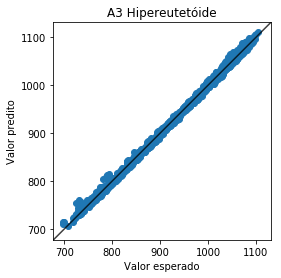

In [19]:
# plt.scatter(y_test, predictions)
# plt.xlabel('True_Values')
# plt.ylabel('Predictions')

# # Draw y = x line
# ymin, ymax = y_test.min(), y_test.max()
# plt.plot([ymin, ymin], [ymax, ymax], 'r-')

# plt.show()

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r-', alpha=0.75, color='black')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Valor esperado')
ax.set_ylabel('Valor predito')
ax.set_title('A3 Hipereutetóide')
plt.savefig('img/A3_hiper.png')

In [20]:
metrics.r2_score(y_test, predictions)

0.997139182983552

In [21]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

5.2775592536129965

In [22]:
#MSE
metrics.mean_squared_error(y_test, predictions)

27.852631675396164

## Hipoeutectoid

In [20]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df_hipo, 0.8)

Train size: (1842, 19)
Test size: (461, 19)


In [21]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
1817,0.3,3.000000,2.250150e+00,2.250025,1.500050,0.09,0.900000,0.450015,0.675007,0.450015,9.000000,4.500150,6.750075,4.500150,5.062894e+00,3.375338e+00,5.062613e+00,3.375150,2.250150e+00
385,0.0,2.250025,1.000000e-08,1.500050,0.000100,0.00,0.000000,0.000000,0.000000,0.000000,5.062613,0.000225,3.375150,0.000225,1.500050e-08,1.000000e-12,2.250150e+00,0.000150,1.000000e-08
2676,0.6,0.750075,2.250150e+00,0.000100,0.750075,0.36,0.450045,0.900030,0.000060,0.450045,0.562613,1.125150,0.000075,0.562613,2.250150e-04,1.687781e+00,1.000000e-08,0.000075,5.626125e-01
376,0.0,2.250025,1.000000e-08,0.000100,0.750075,0.00,0.000000,0.000000,0.000000,0.000000,5.062613,0.000225,0.000225,1.687688,1.000000e-12,7.500750e-09,1.000000e-08,0.000075,5.626125e-01
1462,0.3,0.750075,5.062613e+00,1.500050,1.500050,0.09,0.225022,0.675007,0.450015,0.450015,0.562613,1.687688,1.125150,1.125150,7.594172e+00,7.594172e+00,2.250150e+00,2.250150,2.250150e+00


In [22]:
y_test.head()

968     791.42
1328    830.22
1343    801.82
1300    872.84
489     825.70
Name: A3, dtype: float64

In [23]:
y_train.head()

1817    725.203
385     806.030
2676    756.890
376     802.240
1462    808.480
Name: A3, dtype: float64

In [24]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

957.8334188727475

In [25]:
list(zip(X_test.keys(), model.coef_))

[('C', -434.7524223422389),
 ('Mn', -52.5292969865028),
 ('Si', 19.753551647549457),
 ('Cr', -18.628169931432197),
 ('Ni', -46.481110521756364),
 ('C2', 188.17275481820096),
 ('CMn', 51.438487224528544),
 ('CSi', -41.25224114410301),
 ('CCr', 14.960229019876603),
 ('CNi', 39.07898931460379),
 ('Mn2', 2.3405277755983747),
 ('MnSi', -4.852185165010264),
 ('MnCr', 1.6944416526160957),
 ('MnNi', 4.952581588762136),
 ('SiCr', -0.7773975192921618),
 ('SiNi', -1.8944963088335065),
 ('Cr2', 0.40741378871617684),
 ('CrNi', 1.6170002288773198),
 ('Ni2', 2.1706885591920617)]

In [26]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
filename = 'models/A3_hipo.sav'
pickle.dump(model, open(filename, 'wb'))
predictions = lm.predict(X_test)

### The line / model

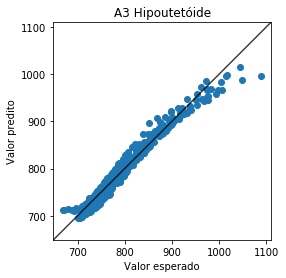

In [30]:
# plt.scatter(y_test, predictions)
# plt.xlabel('True_Values')
# plt.ylabel('Predictions')
# plt.show()

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r-', alpha=0.75, color='black')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Valor esperado')
ax.set_ylabel('Valor predito')
ax.set_title('A3 Hipoutetóide')
plt.savefig('img/A3_hipo.png')

In [31]:

metrics.r2_score(y_test, predictions)

0.9606989663335669

In [32]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

13.909368976910654

In [33]:
#MSE
metrics.mean_squared_error(y_test, predictions)

193.47054533584452

## Hipo & Hipereutectoid

In [27]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df1_, 0.8)

Train size: (5476, 19)
Test size: (1369, 19)


In [28]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

893.2257134168982

In [29]:
list(zip(X_test.keys(), model.coef_))

[('C', -261.1753153220493),
 ('Mn', -40.409609047923155),
 ('Si', 10.112628873981503),
 ('Cr', -7.66764694263189),
 ('Ni', -32.44386325589558),
 ('C2', 216.0753734030949),
 ('CMn', 26.989264493348532),
 ('CSi', -8.378830409182925),
 ('CCr', 25.553020179146003),
 ('CNi', 25.430291611650542),
 ('Mn2', 1.336661055251549),
 ('MnSi', 1.0962279500999488),
 ('MnCr', 1.9547738185634616),
 ('MnNi', 1.7814164625761828),
 ('SiCr', -0.915680001104493),
 ('SiNi', -0.5003619953379947),
 ('Cr2', 0.9852984624601098),
 ('CrNi', 2.2705386323444166),
 ('Ni2', 0.9299984427325296)]

In [31]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
filename = 'models/A3_total.sav'
pickle.dump(model, open(filename, 'wb'))
predictions = lm.predict(X_test)

### The line / model

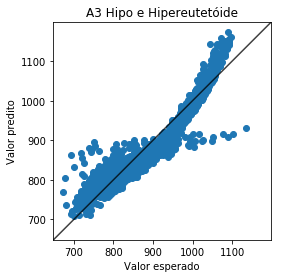

In [38]:
# plt.scatter(y_test, predictions)
# plt.xlabel('True_Values')
# plt.ylabel('Predictions')
# plt.show()

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r-', alpha=0.75, color='black')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Valor esperado')
ax.set_ylabel('Valor predito')
ax.set_title('A3 Hipo e Hipereutetóide')
plt.savefig('img/A3_total.png')

In [39]:
metrics.r2_score(y_test, predictions)

0.8774082232916405

In [40]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

36.91817441410102

In [41]:
#MSE
metrics.mean_squared_error(y_test, predictions)

1362.9516020699828

# A3 regression with database standardization

## Hipereutectoid

In [42]:
df2_ = df_hiper.copy()
df2_ = df2_.loc[~is_na, :]

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_.iloc[:, :-1])
df2_.iloc[:, :-1] = scaler.transform(df2_.iloc[:, :-1])

In [44]:
df2_.head()

,C,Mn,Si,Cr,Ni,A3,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
1273,-2.161098,-1.454925,-1.007144,1.319264,0.664628,-1.770927,-1.58724,-1.263071,-1.223202,-0.565768,...,-1.052287,-0.90719,-0.954937,-0.926840,-0.736294,-0.723239,1.570307,1.633777,0.463410,1
1274,-2.161098,-1.454925,-1.007144,1.319264,1.372755,-1.739327,-1.58724,-1.263071,-1.223202,-0.565768,...,-1.052287,-0.90719,-0.954937,-0.926811,-0.736294,-0.723239,1.570307,2.497379,1.640253,1
1299,-2.161098,-1.454925,-0.836406,1.319264,1.372755,-1.740467,-1.58724,-1.263071,-1.041963,-0.565768,...,-1.052287,-0.90716,-0.954937,-0.926811,-0.502339,-0.486442,1.570307,2.497379,1.640253,1
1398,-2.161098,-0.749968,-1.007144,1.319264,0.664628,-1.783567,-1.58724,-1.079746,-1.223202,-0.565768,...,-0.884473,-0.90716,-0.093992,-0.271865,-0.736294,-0.723239,1.570307,1.633777,0.463410,1
1399,-2.161098,-0.749968,-1.007144,1.319264,1.372755,-1.751656,-1.58724,-1.079746,-1.223202,-0.565768,...,-0.884473,-0.90716,-0.093992,-0.053520,-0.736294,-0.723239,1.570307,2.497379,1.640253,1


In [45]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_, 0.8)

Train size: (3633, 19)
Test size: (909, 19)


In [46]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

0.00043372512136385065

In [47]:
list(zip(X2_test.keys(), model2.coef_))

[('C', 1.4693046746927),
 ('Mn', -0.01724799284255346),
 ('Si', 0.07056540636532181),
 ('Cr', 0.7143779010968048),
 ('Ni', 0.054514158037806806),
 ('C2', -0.3486988257427935),
 ('CMn', 0.00417782910140399),
 ('CSi', 0.10155618468683933),
 ('CCr', -0.3409382539993614),
 ('CNi', -0.01626139050334749),
 ('Mn2', -0.00014813337278275773),
 ('MnSi', 0.04887592504432317),
 ('MnCr', 0.005093231510774718),
 ('MnNi', -0.007395877999905685),
 ('SiCr', -0.0462721245716947),
 ('SiNi', 0.008304533061220296),
 ('Cr2', -0.06268156777012067),
 ('CrNi', 0.013257960271557935),
 ('Ni2', -0.000746306756735364)]

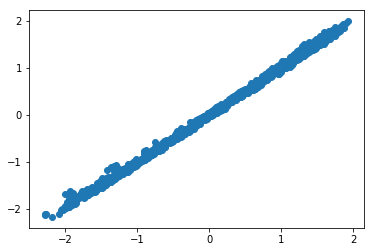

In [48]:
plt.scatter(y2_test, predictions2)
plt.show()

In [49]:
#R2
metrics.r2_score(y2_test, predictions2)

0.997139182983552

In [50]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.0546783834761265

In [51]:
#MSE
metrics.mean_squared_error(y_test, predictions)

1362.9516020699828

## Hipoeutectoid

In [52]:
df2_ = df_hipo.copy()
df2_ = df2_.loc[~is_na, :]

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_.iloc[:, :-1])
df2_.iloc[:, :-1] = scaler.transform(df2_.iloc[:, :-1])

In [54]:
df2_.head()

,C,Mn,Si,Cr,Ni,A3,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
0,-1.179693,-1.357214,-1.028744,-1.226863,-1.344800,1.569570,-0.746339,-0.823016,-0.782522,-0.742131,...,-0.961136,-0.87556,-0.797261,-0.842699,-0.674147,-0.702431,-0.876713,-0.791632,-0.964538,0
1,-1.179693,-1.357214,-1.028744,-1.226863,-0.635113,1.121385,-0.746339,-0.823016,-0.782522,-0.742131,...,-0.961136,-0.87556,-0.797261,-0.842667,-0.674147,-0.702431,-0.876713,-0.791599,-0.791534,0
2,-1.179693,-1.357214,-1.028744,-1.226863,0.074574,0.735739,-0.746339,-0.823016,-0.782522,-0.742131,...,-0.961136,-0.87556,-0.797261,-0.842636,-0.674147,-0.702431,-0.876713,-0.791565,-0.272613,0
3,-1.179693,-1.357214,-1.028744,-1.226863,0.784261,0.398066,-0.746339,-0.823016,-0.782522,-0.742131,...,-0.961136,-0.87556,-0.797261,-0.842604,-0.674147,-0.702431,-0.876713,-0.791532,0.592224,0
4,-1.179693,-1.357214,-1.028744,-1.226863,1.493948,0.098943,-0.746339,-0.823016,-0.782522,-0.742131,...,-0.961136,-0.87556,-0.797261,-0.842572,-0.674147,-0.702431,-0.876713,-0.791499,1.802978,0


In [55]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_, 0.8)

Train size: (1842, 19)
Test size: (461, 19)


In [56]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

-0.0006857339951749364

In [57]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -1.220757751317345),
 ('Mn', -0.7838974743036216),
 ('Si', 0.9413789630864503),
 ('Cr', -0.2776617315229739),
 ('Ni', -0.7013287709834604),
 ('C2', 0.3329909688918003),
 ('CMn', 0.2674032933365116),
 ('CSi', -0.2729033317308881),
 ('CCr', 0.06975535704752955),
 ('CNi', 0.22153366392716367),
 ('Mn2', 0.10795614041913491),
 ('MnSi', -0.16896116194920302),
 ('MnCr', 0.054295557077035816),
 ('MnNi', 0.16780715216185896),
 ('SiCr', -0.07428483966591762),
 ('SiNi', -0.1884908383554977),
 ('Cr2', 0.01811702002569679),
 ('CrNi', 0.05226085211227813),
 ('Ni2', 0.10078943480438048)]

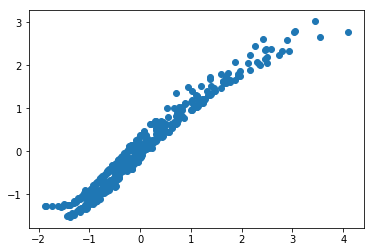

In [58]:
plt.scatter(y2_test, predictions2)
plt.show()

In [59]:
#R2
metrics.r2_score(y2_test, predictions2)

0.9606989663335671

In [60]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.19859694441398792

In [61]:
#MSE
metrics.mean_squared_error(y_test, predictions)

1362.9516020699828

# Summarizing...

### Non-standardized

|  | Hipo | Hiper |
| --- | --- | --- |
| R2 |0.9607|0.9971|
| RMSE |13.9094|5.2775|

### Standardized

|  | Hipo | Hiper |
| --- | --- | --- |
| R2 |0.9607|0.9971|
| RMSE |0.1986|0.0547|

### Next steps
- other metrics: relative percentage error